# Intro to Quantum Darwinism using Qiskit

In this tutorial, we will be using __Qiskit__ to explore the topic of quantum Darwinism. We will generate states of __Spectrum Broadcast Structure (SBS)__, calculate __mutual information__ and plot __Partial Information Plots__. 

### What is Quantum Darwinism?

- In quantum Darwinism it is assumed that through some dynamical interaction between a quantum system and its surrounding environment, information about the quantum system becomes __objective__. This means it can be accessed in a classical sense from the environment. 

- During this process, information about the system is __copied many times__ into the environment, enabling many observers to each access a copy independently. In the literature, this is often called the __proliferation of redundant information__.

- No real-life physical system can be entirely separated from its environment. In general, it is understood that when a system interacts with its environment, it becomes entangled with numerous environmental degrees of freedom. In the field of __open quantum systems__, the impact an environment has on the system has been well studied, and it is known to result in __decoherence__ of the system. Decoherence suppresses quantum interference effects and thus is a key element to understanding the __quantum-to-classical transition__. 

- While open quantum systems and decoherence theory are concerned with *how* the system is affected by its environment, it is not able to answer questions about *what* information is transferred into the environment. Quantum Darwinism does just this. Instead of disregarding the environment as a source of energy dissipation and noise, in quantum Darwinism the environment is an essential information carrier and understanding the process in which the information dissipates is at the core of this theory.

- For an excellent overview of Quantum Darwinism and SBS states, have a look at the review paper by Jarek Korbicz:
https://quantum-journal.org/papers/q-2021-11-08-571/

### Qiskit tools for this tutorial

To begin, we must import some useful Qiskit packages. 

Typically, Qiskit is used for circuit-based quantum algorithms. Here we are exploring ideas that require us to work directly with density matrices and Hamiltonian evolution. Therefore, we will make use of several classes and functions from the `qiskit.quantum_info` module. 

Below is a list of some of the Qiskit classes/functions that we will be using:
- `DensityMatrix`
- `Statevector`
- `partial_trace`
- `random_hermitian`
- `Operator`


In [67]:
from qiskit.quantum_info import DensityMatrix, Statevector, partial_trace, random_hermitian, Operator
from qiskit.circuit.library import HamiltonianGate
from qiskit import QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import permutations
from scipy.linalg import expm


We will also define a helper function `plot_complex` which allows us to visulaise complex valued matrices (like density matrices and Hamiltonians) by separately displaying amplitude and phase.

In [68]:
def plot_complex(complex_matrix, figsize=(10, 10), vmin=0, vmax=None, colour='magma_r'):
    """
    Plot the amplitude and phase of a complex matrix side by side.

    Args:
        complex_matrix (ndarray): Complex-valued matrix to visualize.
        figsize (tuple): Figure size.
        vmin (float): Minimum value for amplitude color scaling.
        vmax (float): Maximum value for amplitude color scaling.
        colour (str): Matplotlib colormap to use.
    """
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs[0].axis('off')
    axs[1].axis('off')

    # amplitude 
    real = axs[0].imshow(np.abs(complex_matrix), cmap=colour, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axs[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar1 = fig.colorbar(real, cax=cax, orientation='vertical')
    cbar1.set_label('amplitude', rotation=90)
    
    # phase
    im = axs[1].imshow(np.angle(complex_matrix), vmin=-np.pi, vmax=np.pi, cmap=colour)
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar2 = fig.colorbar(im, cax=cax, orientation='vertical');
    cbar2.set_label('phase (rad)', rotation=90)
    
    axs[0].set_title(r'Amplitude')
    axs[1].set_title('Phase')
    return fig

## Step 1: Generating an Initial System-Environment Density Matrix

We use the Qiskit classes `Statevector` and `DensityMatrix` here. 

Let us begin by considering a very simple toy model where the quantum system of interest is a single qubit and the surrounding environment consists of $N_E$ qubits. $N_E$ will be a variable that we play with. In any realistic system, $N_E$ will be of the large enough that the environment can be viewed as macroscopic. For these numerical simulations, we can only consider small environments, for example $N_E=4$.

First, we define some key variables.

In [69]:
system_dim = 2 # our system is a qubit
env_dim = 2 # each individual environment system is also a qubit
number_of_environments = 4 # we have chosen N=4, so we have 4 qubits in our environment.

For simplicity, we will begin with our quantum system qubit in an equal superposition of $|0\rangle$ and $|1\rangle$ (i.e. the $|+\rangle$ state):

$$|+\rangle= \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) $$

The corresponding density matrix for this state is

$$ \rho_{S}(0) =  |+\rangle \langle +| = \frac{1}{2}\begin{bmatrix}
1 & 1 \\
1 & 1 
\end{bmatrix}$$

In Qiskit, we generate the state using the `Statevector` class and then convert it into a `DensityMatrix` object.

In [70]:
# Create |+> state vector (equal superposition of |0> and |1>)
plus_state = Statevector([1/2**0.5, 1/2**0.5])

# convert to a density matrix 
sys_rho = DensityMatrix(plus_state)

sys_rho

DensityMatrix([[0.5+0.j, 0.5+0.j],
               [0.5+0.j, 0.5+0.j]],
              dims=(2,))


This gives us the initial density matrix $\rho_S(0)$ for the quantum system.

Next, we define the initial state of the environment. For simplicity, we consider a toy model where all the environment qubits begin in the state $|0\rangle$, before interacting with the system.

We can generate the environment’s initial state as a density matrix in Qiskit as follows:

<function matplotlib.pyplot.show(close=None, block=None)>

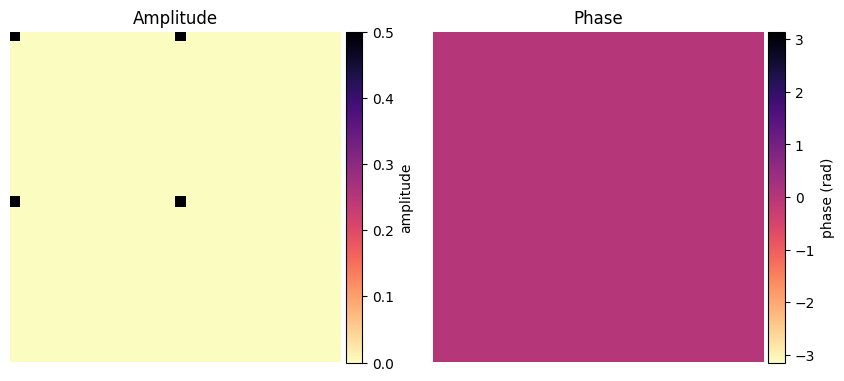

In [71]:
# Create |0> state vector
zero_state = Statevector([1, 0])

# convert to a density matrix
env_rho = DensityMatrix(zero_state)

# Tensor product the system density matrix with all the environment qubits
initial_dm = sys_rho
for i in range(number_of_environments):
    initial_dm = initial_dm.tensor(env_rho)

# plot the total density matrix using the plot_complex function
plot_complex(initial_dm)
plt.show


In [72]:
print(initial_dm)

DensityMatrix([[0.5+0.j, 0. +0.j, 0. +0.j, ..., 0. +0.j, 0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, ..., 0. +0.j, 0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, ..., 0. +0.j, 0. +0.j, 0. +0.j],
               ...,
               [0. +0.j, 0. +0.j, 0. +0.j, ..., 0. +0.j, 0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, ..., 0. +0.j, 0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, ..., 0. +0.j, 0. +0.j, 0. +0.j]],
              dims=(2, 2, 2, 2, 2))


We can also print the density matrix to examine its structure. Notice that the resulting object is an instance of the `DensityMatrix` class, which has a dims attribute indicating the subsystem dimensions. For our case, it shows `dims=(2, 2, 2, 2, 2)`, corresponding to the five qubits (one system qubit plus four environment qubits).

This explicit dimensional information is important because it tells Qiskit how to interpret the composite system, which will be essential when we later perform operations like partial traces over specific subsystems (e.g., tracing out the environment).

## Step 2: The interaction

We model the interaction between the quantum system and its environment using a __Broadcasting Hamiltonian__. This is a Hamiltonian with the following structure:
$$ H=\sum_{i=1}^{d_S} \ket{i}\!\bra{i}_{S} \otimes \sum_{l=1}^{N}  H_l^{(i)} $$

- This structure ensures that each qubit in the environment interacts independently with the system. 

- The environmental qubits do not interact with each other. 

- We call the operator $H^{(i)}_{l}$ the conditional Hamiltonian on the $l$-th environment qubit, conditioned on the quantum system being in the state $\ket{i}$. 

- Importantly, in the sum over $l$, it is implicit that for each __environment block__ in the summation there is a Hamiltonian on the $l$-th environment and all other environments have the identity.

### Generating the Hamiltonian in Qiskit

We will use Qiskit's function `random_hermitian` to generate each conditional Hamiltonian randomly. Then we will tensor product these together to form the entire broadcasting Hamiltonian.

To build the environment blocks that make up the broadcasting Hamiltonian, we generate a list of all binary permutations of '1'. Each on of these permutations forms one of the elements in the summation over $l$, where the position of the '1' indicates the $l$-th position. We will then replace the '1' with a random Hamiltonian and the '0's with the identity forming an environment block. 

For example, with 4 environments, the permutations are:
$$
(1,0,0,0), (0,1,0,0), (0,0,1,0), (0,0,0,1)
$$

We define a function `perm` to generate these permutations.


In [73]:
def perm(number_of_environments):
    """Generate all binary permutations with a single '1'."""
    if not isinstance(number_of_environments, int) or number_of_environments <= 0:
        raise ValueError("number_of_environments must be a positive integer")
    x = [0] * number_of_environments
    x[0] = 1
    return list(set(permutations(x, number_of_environments)))

# test for 4 environments:
perm(4)

[(0, 0, 0, 1), (0, 1, 0, 0), (1, 0, 0, 0), (0, 0, 1, 0)]

Now that we have the permutations marking which environment qubit the Hamiltonian acts on, we build the corresponding environment block.

To efficiently construct the tensor products required, we define a helper function `tensor_list` that takes a list of operators and computes their tensor product using the `.tensor()` Qiskit method.

The function `tensor_prod_env_hams` loops over each permutation, replaces '1' with a random hermitian matrix and '0' with the identity matrix. It then sums all resulting tensor products. This sum forms the total environment block Hamiltonian for the system.

Environment block shape: (16, 16)


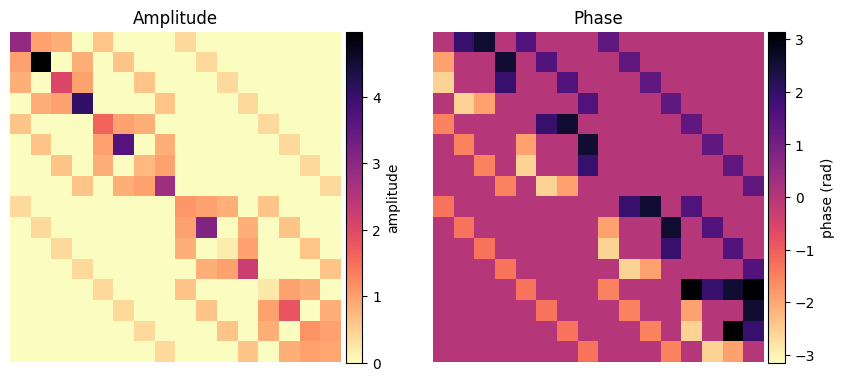

In [74]:
def tensor_list(ops):
    """Tensor a list of operators using the .tensor() method."""
    result = ops[0]
    for op in ops[1:]:
        result = result.tensor(op)
    return result

def tensor_prod_env_hams(number_of_environments, env_dim):
    """
    Generate a block of environment Hamiltonians for identical environments.
    """
    p = perm(number_of_environments)
    for i in range(len(p)):
        p[i] = list(p[i])
        for j in range(number_of_environments):
            if p[i][j] == 1:
                p[i][j] = random_hermitian(env_dim)  # replace '1' with random Hamiltonian
            else:
                p[i][j] = Operator(np.eye(env_dim)) # replace '0's with the identity
    total_tensor_list = [tensor_list(p[i]) for i in range(number_of_environments)]
    return sum(total_tensor_list)

block = tensor_prod_env_hams(4, 2)

print('Environment block shape:', block.data.shape)
plot_complex(tensor_prod_env_hams(4, 2))
plt.show()

Finally, we bring this all together to form the Broadcasting Hamiltonian. The function `total_hamiltonian` generates two environment blocks, one for each state of the qubit system (i=0 and i=1). It then forms a tensor product between the system states $\ket{i}\bra{i}$ and the $i$-th environment block for both $i=0$ and $i=1$. Finally, it adds them together, giving the final Hamiltonian!

We plot the resultant Hamiltonian and see it is Hermitian and that it has a block-diagonal structure with random matrix elements.

Broadcasting Hamiltonian:


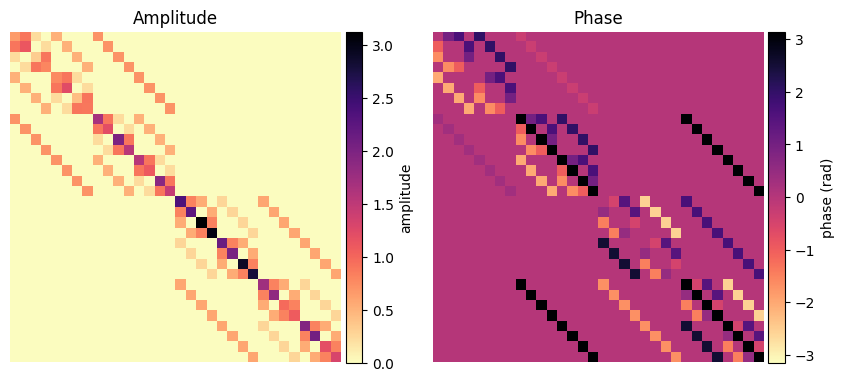

In [75]:
def total_hamiltonian(system_dim, number_of_environments, env_dim):
    blocks = [tensor_prod_env_hams(number_of_environments, env_dim)
              for i in range(system_dim)] # generate an environment block for both possible system states i=0 and i=1
    sys = []
    for i in range(system_dim):
        vec = np.zeros(system_dim)
        vec[i] = 1
        sys_rho = np.outer(vec, vec)  # |i><i|
        sys.append(Operator(sys_rho)) # make the system density matrix a Qiskit Operator
    tensors = [sys[i].tensor(blocks[i]) for i in range(system_dim)] # tensor the system to the environment block
    return sum(tensors)


H = total_hamiltonian(system_dim, number_of_environments, env_dim)
print('Broadcasting Hamiltonian:')
plot_complex(H)
plt.show()

### Evolving the state:

To simulate the dynamics of our system-environment state under the Broadcasting Hamiltonian, we apply the unitary evolution operator
$$
U(t) = e^{-iHt}
$$
where $H$ is our Broadcasting Hamiltonian and $t$ is time.

In Qiskit, we can do this using the `HamiltonianGate` from the `qiskit.circuit.library`. This allows us to exponentiate the Hamiltonian directly as a quantum gate. Then, we apply this gate to the full system-environment state.

Below is a function `evolve_state` which takes an initial state (either `DensityMatrix` or `Statevector`), a Hamiltonian (as a Qiskit Operator), and a time $t$, then returns the evolved state after applying the Hamiltonian evolution.

In [76]:
def evolve_state(initial_state, hamiltonian, t):
    """
    Evolve a density matrix or statevector using HamiltonianGate in Qiskit.
    """
    # Create Hamiltonian evolution gate
    evo_gate = HamiltonianGate(hamiltonian, time=t)

    # Get number of qubits
    num_qubits = int(np.log2(hamiltonian.dim[0]))

    # Build and apply circuit
    qc = QuantumCircuit(num_qubits)
    qc.append(evo_gate, range(num_qubits))

    return initial_state.evolve(qc)


Next, we plot the density matrix of the system-environment $\rho_{SE}(t)$ at several time steps. As time progresses, observe how the system and environment become increasingly correlated. This is indicated by the growth of the amplitude of the off diagonal elements in the density matrix.

These changing correlations are essential to understanding information flow from system to environment, a key idea in quantum Darwinism. 

system-environment density matrix when t=0:


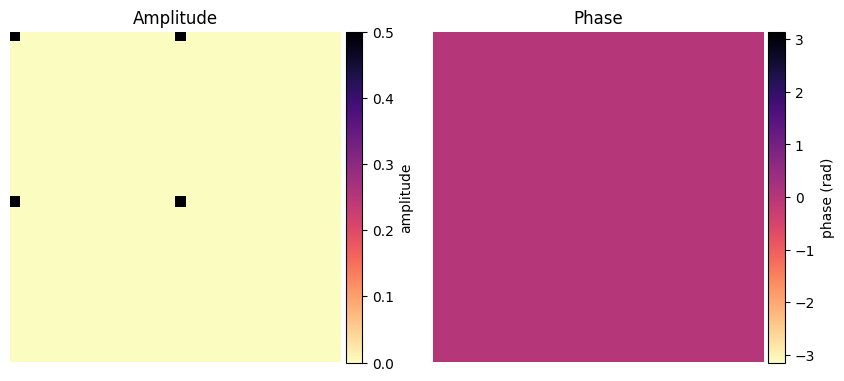

system-environment density matrix when t=0.5:


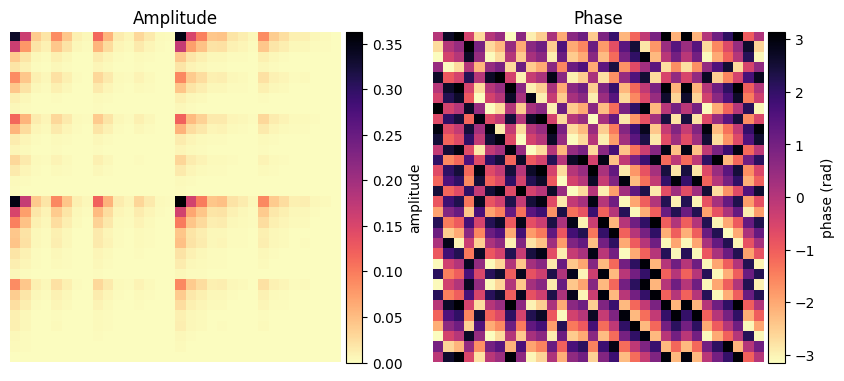

system-environment density matrix when t=1:


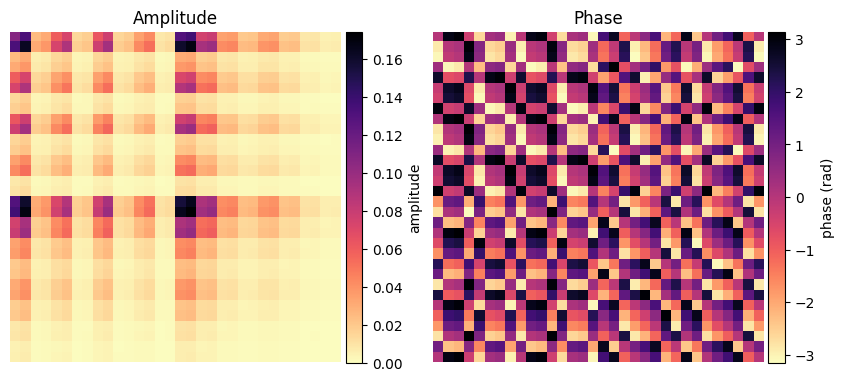

In [79]:
times = [0,0.5,1]

for t in times: 
    evolved_dm = evolve_state(initial_dm, H, t)
    print(f"system-environment density matrix when t={t}:")
    plot_complex(evolved_dm)
    plt.show()


## Step 3: Partial Information Plots

### The Quantum Mutual Information

Quantum Darwinism is often tested with an entropic condition, that, when satisfied,
allows one to claim that the __proliferation of redundant information__ has occurred.

It is based on the quantum mutual information between the system and a considered environment fraction:
$$
    \mathcal{I}(\rho_{S,fE}) = \mathcal{H}\left(\rho_S\right)+\mathcal{H}\left(\rho_{fE}\right)-\mathcal{H}\left(\rho_{S,fE}\right),
$$
where $\mathcal{H}(\rho) = - \operatorname{tr}(\rho \log(\rho))$ is the von Neumann entropy and $\rho_{S,fE} = \operatorname{Tr}_{E/f}(\rho_{S,E})$ is the partial trace of everything in the environment except the considered fraction $fE$. The quantum mutual information is a measure of the correlations present between subsystems. If there exists an environment fraction $f_0$ such that for all fractions larger than it, i.e. $f>f_0$ the mutual information between the system and fraction $f>f_0$ is equivalent to $\mathcal{H}(\rho_S)$:
$$
    \mathcal{I}(\rho_{S,fE})  = \mathcal{H}(\rho_S) \quad \forall \quad f > f_0,
$$
then the state satisfies the definition of objectivity. The motivation behind this is that if there exists some fraction $f_0$ at which the mutual information equals the von Neumann entropy of $S$ and beyond which the mutual information does not increase, this implies the fraction $f_0E$ contains all information about $S$, and one learns nothing by adding more of the environment to the fraction. If one then assumes that every such fraction of size $f_0$ also satisfies this property, then the entire environment has $R=1/f_0$ such fractions and $R$ redundant copies of the system information. Hence, $R$ is the *redundancy* of the information. For example, if $f_0 = 1/5$, there are five disjoint fractions of the same size each containing full information about $S$.

__Note:__ The phrase `for all $f>f_0$' is not strictly precise as in the limit of considering the entire environment (tracing nothing out) we have that for pure global states $\mathcal{I}(\rho_{S:E}) = 2\mathcal{H}(\rho_S)$. Thus, there exists a window or __classical plateau__ in which the mutual information remains approximately constant and equal to $\mathcal{H}(\rho_S)$, before increasing sharply near the full environment size.


We first define functions to calculate Von Neumann entropy and mutual information using the Qiskit function `partial_trace`. 

In [82]:
def calculate_von_neumann_entropy(rho):
    """Calculate the von Neumann entropy of a density matrix rho"""
    eigvals = np.real_if_close(np.linalg.eigvals(rho.data))
    eigvals = eigvals[eigvals > 1e-12]  # ignore tiny negatives/numerical noise
    return -np.sum(eigvals * np.log2(eigvals))

def calculate_mutual_information(rho_full, subsys_A, subsys_B):
    """
    Compute the mutual information I(A:B) = S(rho_A) + S(rho_B) - S(rho_AB)
    
    Parameters:
    - rho_full: qiskit.quantum_info.DensityMatrix or Operator representing full system
    - subsys_A: list of subsystem qubit indices for A (e.g. [0,2])
    - subsys_B: list of subsystem qubit indices for B (e.g. [1])
    
    Returns:
    - mutual information as float
    """
    # Ensure input is a density matrix
    if not isinstance(rho_full, DensityMatrix):
        rho_full = DensityMatrix(rho_full)
        
    # Subsystem indices for full system
    all_qubits = set(range(rho_full.num_qubits))
    
    # Compute reduced density matrices
    rho_A = partial_trace(rho_full, list(all_qubits - set(subsys_A)))
    rho_B = partial_trace(rho_full, list(all_qubits - set(subsys_B)))
    
    # Compute von Neumann entropies
    S_A = calculate_von_neumann_entropy(rho_A)
    S_B = calculate_von_neumann_entropy(rho_B)
    S_AB = calculate_von_neumann_entropy(rho_full)
    
    return S_A + S_B - S_AB


In [83]:
# test by looking at our system and all 4 environment qubits:
subsys_A = [0] # the first subsystem is always the system qubit
subsys_B = [1,2,3,4] # let the second subsystem be the entire environment

mutual_info = calculate_mutual_information(evolved_dm, subsys_A, subsys_B)
print(mutual_info)

1.4362595589300255


### Plotting a Partial Information Plot

We now want to explore how the mutual information changes with environment fraction size. This is visualized when looking at __partial information plots (PIPs)__. PIPs show the mutual information between the system and a fraction of the environment, normalized by the system’s entropy:
 $$ \frac{\mathcal{I}(\rho_{S:E}) }{ \mathcal{H}(\rho_S)}$$
plotted against the fraction size $f$. 

A system exhibiting quantum Darwinism will produce a curve that:
- Starts near zero for very small fractions (little information),
- Rapidly rises to approximately 1 as the fraction size increases (indicating the fraction contains nearly complete information about the system),
- Remains near 1 over a wide range of fraction sizes (the classical plateau),
- Then finally rises to 2 as the fraction approaches the full environment size, reflecting the pure global state where the mutual information doubles the system entropy.

In our simulation, we use Qiskit's `partial_trace` function to trace out varying fractions of the environment. Starting from a single environment qubit, we iteratively include more qubits in the considered fraction until the full environment is included.

For each fraction size, we calculate the normalized mutual information between the system and the environment fraction. Plotting this against the fraction size allows us to observe the presence (or absence) of a __classical plateau__.

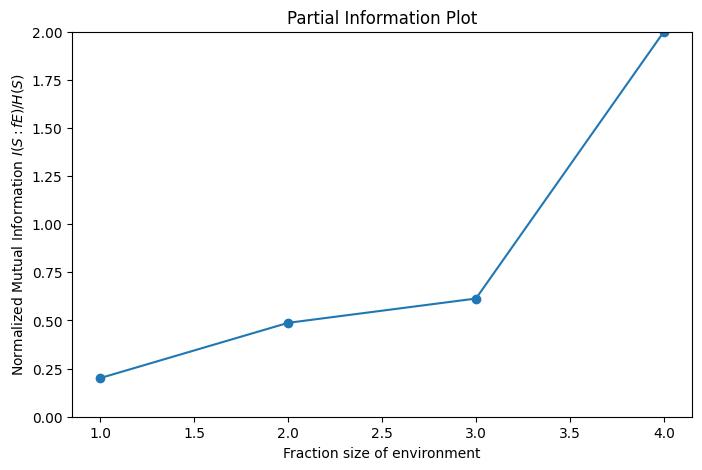

In [89]:
# entropy of system (for normalisation of the mutual information)
state_system = partial_trace(evolved_dm, [1,2,3,4])
entropy_system = calculate_von_neumann_entropy(state_system)

fraction_sizes = np.arange(1,number_of_environments+1)

mutual_infos = []
for i in fraction_sizes:
    # Keep qubit 0 and first i environment qubits, trace out the rest
    keep_indices = list(range(i + 1))
    trace_out_indices = [j for j in range(evolved_dm.num_qubits) if j not in keep_indices]
    
    frag = partial_trace(evolved_dm, trace_out_indices)
    # Mutual information between qubit 0 and the other i qubits
    MI = mutual_information(frag, [0], list(range(1, frag.num_qubits)))
    mutual_infos.append(MI / entropy_system) # normalise mutual information by dividing by the system entropy
    
# Plot Partial Information Plot
plt.figure(figsize=(8,5))
plt.plot(fraction_sizes, mutual_infos, marker='o')
plt.xlabel("Fraction size of environment")
plt.ylabel("Normalized Mutual Information $I(S:fE)/H(S)$")
plt.title("Partial Information Plot")
plt.ylim(0,2)
plt.show()

Our considered example only has 4 qubits in the environment. This only gives us 4 data points in our PIP. Therefore, it is a good idea to try a larger environment. Below, we consider a 6 qubit environment. 

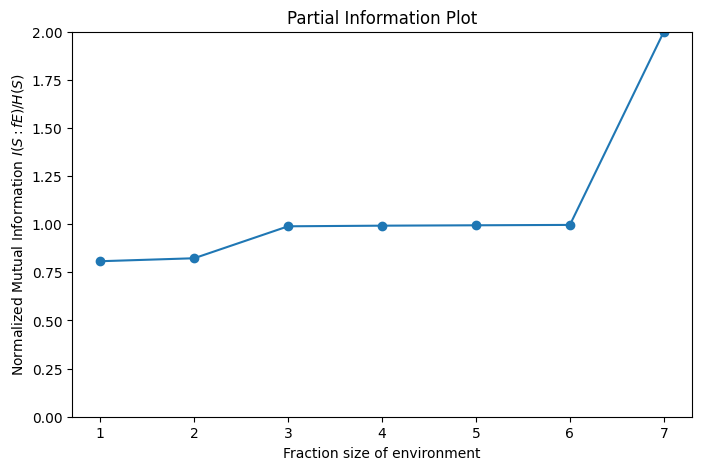

In [97]:
system_dim = 2 # our system is a qubit
env_dim = 2 # each individual environment system is also a qubit
number_of_environments = 7

# Create |0> state vector
zero_state = Statevector([1, 0])

# convert to a density matrix
env_rho = DensityMatrix(zero_state)

# Tensor product the system density matrix with all the environment qubits
initial_dm = sys_rho
for i in range(number_of_environments):
    initial_dm = initial_dm.tensor(env_rho)

H = total_hamiltonian(system_dim, number_of_environments, env_dim)

t=10
evolved_dm = evolve_state(initial_dm, H, t)

# entropy of system
state_system = partial_trace(evolved_dm, list(range(1, number_of_environments + 1)))
entropy_system = calculate_von_neumann_entropy(state_system)

fraction_sizes = np.arange(1,number_of_environments+1)

mutual_infos = []
for i in fraction_sizes:
    # Keep qubit 0 and first i environment qubits => trace out the rest
    keep_indices = list(range(i + 1))
    trace_out_indices = [j for j in range(evolved_dm.num_qubits) if j not in keep_indices]
    
    frag = partial_trace(evolved_dm, trace_out_indices)
    # Mutual information between qubit 0 and the other i qubits
    MI = mutual_information(frag, [0], list(range(1, frag.num_qubits)))
    mutual_infos.append(MI / entropy_system)
    
# Plot Partial Information Plot
plt.figure(figsize=(8,5))
plt.plot(fraction_sizes, mutual_infos, marker='o')
plt.xlabel("Fraction size of environment")
plt.ylabel("Normalized Mutual Information $I(S:fE)/H(S)$")
plt.title("Partial Information Plot")
plt.ylim(0,2)
plt.show()

## Step 3: Spectrum Broadcast Structure States

While PIP’s provide a visual illustration of quantum Darwinism, they can be limiting because it’s not always
obvious what qualifies as a __classical plateau__. Another downside to this description is that it
provides no obvious way to operationally access the information about the system that is supposed to
be encoded in a fraction of the environment.

For this reason, among others, there was motivation to approach the emergence of
objectivity from a different, more operational direction. This resulted in states of spectrum
broadcast structure (SBS). 

It turns out that requiring a state conform to SBS is a stronger condition than quantum Darwinism, and is
equivalent to so-called ‘strong quantum Darwinism’ combined with another condition called
‘strong independence’. Therefore, any state that is of SBS structure implies quantum Darwinism. 

To test this, we will generate an SBS state and plot its corresponding partial information plot. we expect that the plot will have a classical plateau. 

System-environment states of spectrum broadcast structure have the following form:
$$
    \rho^{\mathrm{SBS}} =\sum_{i=1}^{d_{S}} p_{i} \ket{i}\! \bra{i}_{S} \bigotimes_{k=1}^{N}\rho_k^{(i)},
$$
where the observer states $\left\{\rho_{k}^{(i)}\right\}_{i}$ are orthogonal, satisfying:
$$
\rho_k^{(i)}\rho_k^{(j)}=0,
$$
for all $i\neq j$ and for all observers $k$. This is equivalent to $F\left(\rho_k^{(i)}, \rho_k^{(j)}\right) = 0$, where $F(\rho, \sigma)=\left(\operatorname{tr} \sqrt{\sqrt{\rho} \sigma \sqrt{\rho}}\right)^2$ is the fidelity.

We will generate a very simple SBS state in which the observer state $\rho_{k}^{(0)} = \ket{+}\bra{+}$ and $\rho_{k}^{(1)} = \ket{-}\bra{-}$. This results in a state:
$$
\rho^{\mathrm{SBS}} = \frac{1}{2} \ket{0}\! \bra{0}_{S} \bigotimes_{k=1}^{N} \ket{+}\! \bra{+}_{k} + \frac{1}{2} \ket{1}\! \bra{1}_{S} \bigotimes_{k=1}^{N} \ket{-}\! \bra{-}_{k}
$$
where $N$ is the number of environment qubits.

To generate this state using Qiskit we define a function `generate_rho_SBS` which works for any number of environment qubits.

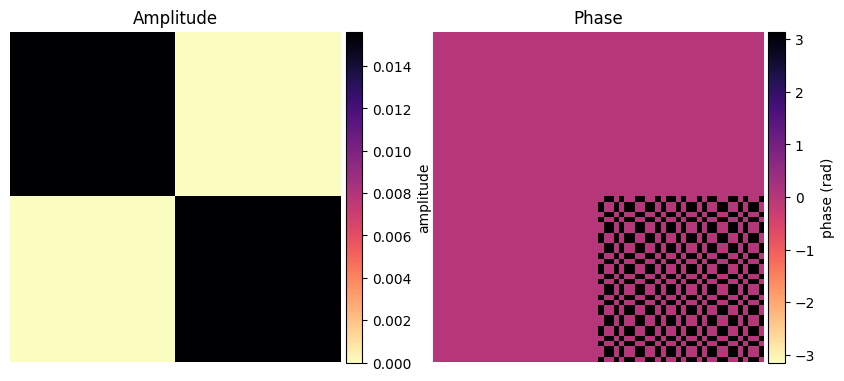

In [102]:
def generate_rho_SBS(number_of_environments):
    """
    Constructs the SBS state:
    (1/2) |0><0|_S ⊗_{k=1}^N |+><+|_k + (1/2) |1><1|_S ⊗_{k=1}^N |-><-|_k
    where qubit 0 is the system and the rest are environments.
    """
    # Basis states for the system
    ket0 = Statevector.from_label('0')
    ket1 = Statevector.from_label('1')

    # |+> and |-> states for the environment qubits
    ket_plus  = Statevector([1/np.sqrt(2), 1/np.sqrt(2)])
    ket_minus = Statevector([1/np.sqrt(2), -1/np.sqrt(2)])

    # Tensor product of all environment |+> and all environment |->
    env_plus  = ket_plus
    env_minus = ket_minus
    for _ in range(number_of_environments):
        env_plus  = env_plus.tensor(ket_plus)
        env_minus = env_minus.tensor(ket_minus)

    # First term: |0><0| ⊗ (|+><+|)^{⊗ N}
    term1 = DensityMatrix(ket0.tensor(env_plus)) * 0.5

    # Second term: |1><1| ⊗ (|-><-|)^{⊗ N}
    term2 = DensityMatrix(ket1.tensor(env_minus)) * 0.5

    # Sum to get the full density matrix
    rho = term1 + term2

    return rho

number_of_environments=4
rho_SBS = generate_rho_SBS(number_of_environments)

plot_complex(rho_SBS)
plt.show()

Finally, we plot a (Partial Information Plot (PIP) for this SBS state. 

We expect the normalized mutual information to remain flat at the value 1 for all of the considered fraction sizes. This is because the SBS state perfectly encodes the system information identically in each fraction of the environment. So each fraction has full information about the system, resulting in a __classical plateau__ in the PIP.

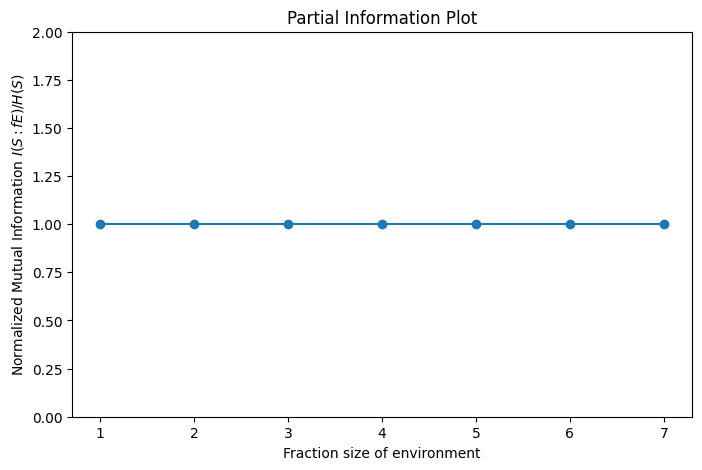

In [103]:
number_of_environments=7
rho_SBS = generate_rho_SBS(number_of_environments)

# entropy of system
state_system = partial_trace(rho_SBS, list(range(1, number_of_environments + 1)))
entropy_system = calculate_von_neumann_entropy(state_system)

fraction_sizes = np.arange(1,number_of_environments+1)

mutual_infos = []
for i in fraction_sizes:
    # Keep qubit 0 and first i environment qubits => trace out the rest
    keep_indices = list(range(i + 1))
    trace_out_indices = [j for j in range(rho_SBS.num_qubits) if j not in keep_indices]
    
    frag = partial_trace(rho_SBS, trace_out_indices)
    # Mutual information between qubit 0 and the other i qubits
    MI = mutual_information(frag, [0], list(range(1, frag.num_qubits)))
    mutual_infos.append(MI / entropy_system)
    
# Plot Partial Information Plot
plt.figure(figsize=(8,5))
plt.plot(fraction_sizes, mutual_infos, marker='o')
plt.xlabel("Fraction size of environment")
plt.ylabel("Normalized Mutual Information $I(S:fE)/H(S)$")
plt.title("Partial Information Plot")
plt.ylim(0,2)
plt.show()

We see from the PIP above that the SBS state exhibits a perfect __classical plateau__, with the mutual information equalling the system's Von Neumann entropy for all fraction sizes. 

SBS states are __classical-quantum states__ meaning there is no entanglement between the system and the environment, only classical correlations. As a result, the mutual information between the system and environment fractions can never exceed the system's entropy. This is why, unlike the previous PIP plots, the normalized mutual information does not rise to 2 when considering the entire environment.

### Conclusion and Next Steps

In this tutorial, we used Qiskit’s `Statevector`, `DensityMatrix` classes and useful functions like `partial_trace` and `random_hermitian` to explore the topic of quantum Darwinism. We generated initial system-environment states, constructed random broadcasting Hamiltonians, evolved the joint state over time, and visualized correlations using partial information plots. Finally, we compared these results to states of Spectrum Broadcast Structure (SBS) and showed how the structure of SBS states mean classical information about a system is perfectly encoded in all fractions of the environment.

Next time, we will further explore SBS states, including how to use distance measures to quantify how close a general state is to an SBS state. We will discuss how they are a useful tools for exploring the emergence of objectivity and the quantum-to-classical transition. 

